In [291]:
import os
from gensim.models import KeyedVectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import f1_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import tqdm
from collections import Counter
from langdetect import detect

Побудуйте класифікатор, який буде предбачати категорію запиту до служби 1551 з використанням тільки векторів слів (не використовувати інших фічі, такі як самі слова, нграми і т.д).

## Data loading and preprocessing

In [292]:
model = KeyedVectors.load_word2vec_format('word2vec', binary=False)
model.init_sims(replace=True)

In [293]:
class FileParser:
    def __init__(self):
        self.documents = []
        self.state = "empty"
        self.current = {}
    
    def process_line(self, line, category):
        if line.strip().isnumeric():
            self.state = "id"
            self.current['id'] = line.strip().lower()
        elif self.state == "id" or (self.state == 'text' and line != '\n'):
            self.state = 'text'
            current_text = self.current.get("text", "")
            self.current['text'] = current_text + line.lower().replace("\n", " ")
        elif line == '\n' and self.state != 'newline':
            self.state = 'newline'
        elif line == '\n' and self.state == 'newline':
            self.state = "empty"
            self.current['category'] = category
            self.documents.append(self.current)
            self.current = {}
            

### Parse TXT File

In [302]:
# Parsing txt files
DATA_PATH = "data"
parser = FileParser()
for file_name in tqdm.tqdm_notebook(os.listdir(DATA_PATH)):
    category = file_name.split(".")[0]
    with open(f"{DATA_PATH}/{file_name}", encoding='utf-8', errors='ignore') as file:  
        for line in file:
            parser.process_line(line, category)

In [303]:
documents = parser.documents
categories = {doc['category'] for doc in documents}

### Validate and filter documents by lang and available text

In [304]:
def valid_doc(doc):
    contains_text = "text" in doc
    if contains_text:
        try:
            is_uk = detect(doc['text']) == 'uk'
            return is_uk
        except:
            print(f"Can't detect lang for text: {doc['text']}")
            return False
    
    return contains_text

#Filter not relevant documents
documents = [doc for doc in tqdm.tqdm_notebook(documents) if valid_doc(doc)]

Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't dete

Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text: 2/09/2015 
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text: 2/09/2015 
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text:  
Can't detect lang for text: http://www.amc.gov.ua/amku/control/main/uk/publish/pri

In [305]:
class Vectorizer:
    def __init__(self, w2v, stopwords):
        self.w2v = w2v
        self.stopwords = stopwords
    
    def vectorize_text(self, text):
        result = np.zeros((300))
        vectors = []
        for word in text.split(" "):
            if word in self.w2v and word not in self.stopwords and len(word) > 0:
                vector = self.w2v.get_vector(word)
                result += vector
                vectors.append(vector)
        return result, vectors


In [306]:
label_encoder = LabelEncoder().fit(list(categories))
vectorizer = Vectorizer(model, [])
for doc in tqdm.tqdm_notebook(documents):
    aggregated_vector, vectors = vectorizer.vectorize_text(doc['text'])
    doc['vector'] = aggregated_vector
    doc['word_vector'] = vectors
    doc['y'] = label_encoder.transform([doc['category']])[0]
    

In [307]:
X = documents
labels = [doc['y'] for doc in documents]
train, test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.3)

In [308]:
x_train = [x['vector'] for x in train]
x_test = [x['vector'] for x in test]

## Task 1

Можете використайте фільтрацію мови, щоб відібрати тільки україномовні запити.


1. У якості безйлайну використайте класифікатор kNN, який буде шукати найближчі за косинусною відстанню вектори запитів, утворені сумуванням векторів всіх слів запиту.

In [309]:
neigh = NearestNeighbors(1, n_jobs=-1, metric='cosine')
neigh.fit(x_train, y_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=1, p=2, radius=1.0)

In [310]:
predicted = neigh.kneighbors(x_test, 1, return_distance=False)

In [311]:
y_predicted = np.array(y_train)[predicted].reshape(-1)

In [312]:
f1_w, f1_m = f1_score(y_test, y_predicted, average='weighted'), f1_score(y_test, y_predicted, average='macro')
print(f"F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

F1 weighted: 0.383 | F1 macro: 0.293


## Task 2

2. Розробіть покращений класифікатор, для якого використайте іншу модель класифікації, яка би присвоювала ваги окремим елементам вектора (наприклад, Logistic Regression, SVM, Random Forest). Також можете зробити додаткові покращення, такі як:

  - здійснювати попередню фільтрацію і відбирати тільки частину векторів для представлення

  - використовувати лематизацію та інші форми нормалізації

  - робити зваження векторів

  - додатково використовувати інші способи побудувати вектор документу (наприклад, TF-IDF, LDA, ...)

In [313]:
from sklearn.linear_model import SGDClassifier

In [314]:
%%time
linear = SGDClassifier(loss='log', alpha=0.000001, penalty='l1',
                       max_iter=50, random_state=42, n_jobs=-1,
                       verbose=0).fit(x_train, y_train)

CPU times: user 19min 5s, sys: 3.28 s, total: 19min 8s
Wall time: 5min


/Users/sasha/programming/edu/ucu/nlp/.env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [315]:
logreg_predict = linear.predict(x_test)
f1_w, f1_m = f1_score(y_test, logreg_predict, average='weighted'), f1_score(y_test, logreg_predict, average='macro')
print(f"Test Score | F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

Test Score | F1 weighted: 0.418 | F1 macro: 0.346


### Removing stopwords from text

In [316]:
with open("uk-stopwords.txt") as f:
    stopwords = f.read().split("\n")

In [317]:
label_encoder = LabelEncoder().fit(list(categories))
vectorizer = Vectorizer(model, stopwords)
for doc in tqdm.tqdm_notebook(documents):
    aggregated_vector, vectors = vectorizer.vectorize_text(doc['text'])
    doc['vector'] = aggregated_vector
    doc['word_vector'] = vectors
    doc['y'] = label_encoder.transform([doc['category']])[0]
    

In [318]:
X = documents
labels = [doc['y'] for doc in documents]
train, test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.3)

In [319]:
x_train = [x['vector'] for x in train]
x_test = [x['vector'] for x in test]

### Running classifier again

In [340]:
%%time
linear = SGDClassifier(loss='log', alpha=0.000001, penalty='l1',
                       max_iter=50, random_state=42, n_jobs=-1,
                       verbose=0).fit(x_train, y_train)

CPU times: user 23min 23s, sys: 14.1 s, total: 23min 37s
Wall time: 8min 33s


/Users/sasha/programming/edu/ucu/nlp/.env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [341]:
logreg_predict = linear.predict(x_test)
f1_w, f1_m = f1_score(y_test, logreg_predict, average='weighted'), f1_score(y_test, logreg_predict, average='macro')
print(f"Test Score | F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

Test Score | F1 weighted: 0.406 | F1 macro: 0.334


### Removing stopwords doesn't improve quality

## Task 3

3. Розробіть класифікатор на основі нейромережі: або feed-forward з використанням агрегованого вектору, або LSTM (чи BiLSTM), що проходить по всьому тексту. 

In [345]:
import torch
import torch.nn as nn
from torch.utils import data
from torch.functional import F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_sequence

In [346]:
# Pad batch to the same seq len
def padding_collate(batch):
    data = [item[0] for item in batch]
    data = pad_sequence(data, batch_first=True)
    targets = torch.cat([item[1] for item in batch])
    return [data, targets]

class DataLoader(data.Dataset):
    def __init__(self, data, max_len=50):
        self.data = [doc for doc in data if len(doc['word_vector']) > 1]
        self.max_len=max_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        doc = self.data[idx]
        vector = np.array(doc['word_vector'])[:self.max_len]
        label = doc['y']
        return torch.from_numpy(vector).float(), torch.from_numpy(np.array([label])).long()

### Define Training 

In [347]:
class Trainer:
    def __init__(self, net, config, lr=0.001, l2_rate=0):
        net.train()
        net.to(config['DEVICE'])
        self.device = config['DEVICE']
        self.net = net
        self.config = config
        self.optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=l2_rate)
        self.loss = nn.CrossEntropyLoss()
        self.losses = []

    def run(self, dataloader, epochs=1):
        print(">> Running trainer")
        for epoch in range(epochs):
            print(">>> Epoch %s" % epoch)
            for idx, (vectors, target) in enumerate(tqdm.tqdm_notebook(dataloader, ascii=True)):
                vectors, target = vectors.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                predict = self.net(vectors)
                loss = self.loss(predict, target)
                loss.backward()
                self.losses.append(loss.item())
                self.optimizer.step()
                if idx % 400 == 0:
                    print(">>> Loss: {}".format(np.mean(self.losses[-10:])))

                if self.config['DEBUG'] == True:
                    break
            print("Trainer epoch finished")


### Define evaluation

In [348]:
class Evaluation:
    def __init__(self, net, config):
        net.eval()
        net.to(config['DEVICE'])
        self.device = config['DEVICE']
        self.net = net
        self.config = config
        self.loss = nn.CrossEntropyLoss()

    def run(self, dataloader):
        print(">> Running Evaluation")
        predicted = []
        labels = []
        with torch.no_grad():
            for idx, (image, target) in enumerate(tqdm.tqdm_notebook(dataloader, ascii=True)):
                image, target = image.to(self.device), target.to(self.device)
                predict = self.net(image)
                pred = F.softmax(predict, 1).argmax(dim=1, keepdim=True)
                predicted.extend(list(pred.numpy()))
                labels.extend(list(target.view_as(pred).numpy()))
                if self.config['DEBUG'] == True:
                    break

        print("Evaluation finished")
        return {
            'f1_weighted': f1_score(labels, predicted, average='weighted'),
            'f1_macro': f1_score(labels, predicted, average='macro')

        }

### Define Network

In [358]:
class Network(nn.Module):
    def __init__(self, categories_count):
        super(Network,self).__init__()
        hidden_size = 100
        self.lstm = nn.LSTM(input_size=300, hidden_size=hidden_size, batch_first=True,
                            num_layers=1, bidirectional=False)
        self.linear = nn.Linear(hidden_size * 3, categories_count)
    
    def forward(self, input):
        out, (h0, c0) = self.lstm(input)
        out = out[:, -1:, :].transpose(0, 1)
        out = torch.cat((out, h0, c0), 2)[0]
        out = self.linear(F.relu(out))
        return out

In [359]:
config = {
    'DEBUG': False,
    'CUDA': torch.cuda.is_available(),
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

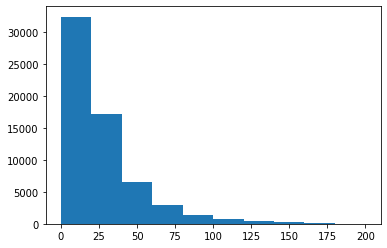

In [360]:
vectors_lens = np.array([len(doc['word_vector']) for doc in documents])
#Value that can be used as upper limit for LSTM seq len
seq_len = int(np.quantile(vectors_lens, .90))
# Number of vector counts per document (distribution) 
_ = plt.hist(vectors_lens)

In [361]:
net = Network(len(categories))

In [362]:
train_data = DataLoader(train, max_len=seq_len)
test_data = DataLoader(test, max_len=seq_len)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=2, shuffle=False, collate_fn=padding_collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=2, shuffle=False, collate_fn=padding_collate)

In [363]:
trainer = Trainer(net, config, lr=0.01, l2_rate=1e-5)
evaluation = Evaluation(net, config)

In [364]:
for i in range(10):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 5.235105991363525
>>> Loss: 4.3908915519714355
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.09655110604352615, 'f1_macro': 0.009396328601963768}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.09456387077474929, 'f1_macro': 0.008713736407547553}
>> Running trainer
>>> Epoch 0


>>> Loss: 3.8205539703369142
>>> Loss: 3.1506368637084963
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.24785820577456685, 'f1_macro': 0.05088687360449753}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.2425759815517387, 'f1_macro': 0.0484893452308696}
>> Running trainer
>>> Epoch 0


>>> Loss: 2.5729610204696653
>>> Loss: 2.539376425743103
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.3564215031634467, 'f1_macro': 0.12750583811629101}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.3394017253070774, 'f1_macro': 0.11143039831909828}
>> Running trainer
>>> Epoch 0


>>> Loss: 2.1144041776657105
>>> Loss: 2.16889910697937
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.41334248567152776, 'f1_macro': 0.18643676482561877}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.3848225756742922, 'f1_macro': 0.15461147411543907}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.8995880961418152
>>> Loss: 1.985366201400757
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.45389342324006293, 'f1_macro': 0.23458523035711218}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.41198815014238754, 'f1_macro': 0.18923518488136612}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.7336170196533203
>>> Loss: 1.8316847085952759
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.4910021248530335, 'f1_macro': 0.2795505445537405}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4371322776491343, 'f1_macro': 0.22011372913925123}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.5947080373764038
>>> Loss: 1.7190400600433349
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5160079760717126, 'f1_macro': 0.3197077205688633}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4487213732987615, 'f1_macro': 0.24109662294119616}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.488954782485962
>>> Loss: 1.6124165534973145
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5450577132197321, 'f1_macro': 0.3595771342039086}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46454322529178177, 'f1_macro': 0.260374784307287}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4018668413162232
>>> Loss: 1.4932612895965576
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5671477799572949, 'f1_macro': 0.3932398120828325}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4695852098180507, 'f1_macro': 0.27429130595867607}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.3512339830398559
>>> Loss: 1.4344612598419189
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5838087276428794, 'f1_macro': 0.4207496561476055}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.47264789086631603, 'f1_macro': 0.28485490500834176}


In [365]:
trainer = Trainer(net, config, lr=0.001, l2_rate=1e-5)
evaluation = Evaluation(net, config)
for i in range(10):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 1.5131094455718994
>>> Loss: 1.1915362536907197
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.6560373400056358, 'f1_macro': 0.5189963901817295}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5060578911848793, 'f1_macro': 0.3263619135697875}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.0498349368572235
>>> Loss: 1.0964420139789581
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.6731801970219178, 'f1_macro': 0.5444009037541222}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.509300747868522, 'f1_macro': 0.33070549703788904}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.0200837314128877
>>> Loss: 1.0404276430606842
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.6857817657692603, 'f1_macro': 0.5645964697883058}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5107524124169446, 'f1_macro': 0.33306198222738653}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.9831374108791351
>>> Loss: 0.9990274846553803
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.6980047179501265, 'f1_macro': 0.5825284547400441}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5095786554791621, 'f1_macro': 0.3344544538747077}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.9494922518730163
>>> Loss: 0.963718056678772
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7082281848352527, 'f1_macro': 0.5963592450836364}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5098707662762817, 'f1_macro': 0.33627890721488596}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.9190175235271454
>>> Loss: 0.920563668012619
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.71749698897825, 'f1_macro': 0.6091663149431157}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5083635123845102, 'f1_macro': 0.3342085180312537}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.8846714794635773
>>> Loss: 0.880657285451889
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7268996302253845, 'f1_macro': 0.6219687368829616}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5065843876822907, 'f1_macro': 0.33166429412396514}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.856626158952713
>>> Loss: 0.841754287481308
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.735396606401952, 'f1_macro': 0.6362377377113535}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5072938715653693, 'f1_macro': 0.33480853660078963}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.8213416874408722
>>> Loss: 0.8084483444690704
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7456380851752575, 'f1_macro': 0.6512669335330815}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5078773487817975, 'f1_macro': 0.3388191821810324}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7973391234874725
>>> Loss: 0.7757346242666244
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7544625539310649, 'f1_macro': 0.6617601466756908}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5070839837283849, 'f1_macro': 0.3382328491559528}


In [366]:
trainer = Trainer(net, config, lr=0.0001, l2_rate=1e-5)
evaluation = Evaluation(net, config)
for i in range(10):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 1.0243219137191772
>>> Loss: 0.7560348868370056
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7685728450632568, 'f1_macro': 0.6866495386112594}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.511185163521889, 'f1_macro': 0.34215486539700285}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7344521701335907
>>> Loss: 0.7353523194789886
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7730348704848232, 'f1_macro': 0.6933744107667537}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5119210098066188, 'f1_macro': 0.34257982381320545}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7360185623168946
>>> Loss: 0.7258483171463013
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7762548079450409, 'f1_macro': 0.6979967830653894}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5103801872152942, 'f1_macro': 0.34213248858887957}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7328279912471771
>>> Loss: 0.7192842781543731
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.778530194608766, 'f1_macro': 0.7025950882102259}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5100524050447417, 'f1_macro': 0.34136693808087226}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7279239773750306
>>> Loss: 0.713688725233078
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7809926411952659, 'f1_macro': 0.7064764003743206}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.509707122611271, 'f1_macro': 0.34119669017489074}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.722545862197876
>>> Loss: 0.7085510134696961
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7831671269304898, 'f1_macro': 0.7095786019742254}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5099290831724992, 'f1_macro': 0.34017974247210264}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7170731544494628
>>> Loss: 0.703573077917099
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7850957906687993, 'f1_macro': 0.7114895718739418}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5094661013777215, 'f1_macro': 0.33926250751361825}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7116670608520508
>>> Loss: 0.698568868637085
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7870310260359108, 'f1_macro': 0.7149675210893044}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5096734794811235, 'f1_macro': 0.33920213833930074}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7067119240760803
>>> Loss: 0.6940746128559112
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7888072936759654, 'f1_macro': 0.7177036306132222}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.509789704170597, 'f1_macro': 0.3384813932718008}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7013035476207733
>>> Loss: 0.6894329190254211
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7910317377932136, 'f1_macro': 0.7206901471988754}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5093393904880633, 'f1_macro': 0.3381343484057252}


### Final result

##### Test res: f1_weighted -  0.511185163521889, f1_macro - 0.34215486539700285